In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from tqdm import tqdm
import ot
from scipy.spatial.distance import pdist, squareform
from sklearn import manifold
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

from helper_functions import *

maindir = "/Users/hieunguyen/data/WGS_features"
outdir = "/Users/hieunguyen/data/outdir"
data_version = "20240822"
PROJECT = "WGS_feature_dist_distance"
output_version = "20240822"
feature_name = "EM"

if feature_name == "flen":
    n = 301
elif feature_name == "EM":
    n = 256
elif feature_name == "Nucleosome":
    n = 601
path_to_feature = os.path.join(maindir, data_version, "feature")
path_to_metadata = os.path.join(maindir, data_version, "metadata")

path_to_main_output = os.path.join(outdir, PROJECT, output_version)
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_02_output = os.path.join(path_to_main_output, "02_output")

os.system("mkdir -p {}".format(path_to_02_output))

metadata = pd.read_csv(os.path.join(path_to_01_output, "metadata.filtered.csv"))

metadata = metadata[metadata["Run"].isin(["R5434", "R5451", "R5601"]) == False]

controldf = pd.read_csv(os.path.join(path_to_01_output, "Control.{}.csv".format(feature_name)), index_col = [0])

sample_list = dict()
for run in metadata.Run.unique():
    sample_list[run] = metadata[(metadata.Run == run) & (metadata.Label == "Control")].SampleID.tolist()
    
run_metadata = pd.read_csv(os.path.join(path_to_metadata, "RUN_metadata.csv"))

##### define training runs and testing runs, any run before R5253 is used for training, the rest is used for testing
training_run = ['R5044',
                'R5063',
                'R5083',
                'R5097',
                'R5119',
                'R5151',
                'R5167',
                'R5168',
                'R5169',
                'R5170',
                'R5184',
                'R5201',
                'R5219',
                'R5253']

maindf = pd.read_csv(os.path.join(path_to_01_output, "{}.csv".format(feature_name)))

training_control_samples = metadata[(metadata['Run'].isin(training_run)) & (metadata["Label"] == "Control")]["SampleID"].unique()
testing_samples = metadata[(~metadata['Run'].isin(training_run))]["SampleID"].unique()
controldf_train = controldf[training_control_samples].copy()
dftest = maindf[testing_samples].copy()

##### calculate the bary center for training samples
training_control_barycenter = calculate_barycenter(controldf_train.to_numpy())

##### caclulate the OT distance from testing samples to "training samples" barycenter
resdf = pd.DataFrame(data = testing_samples, columns=["SampleID"])
resdf = resdf.merge(metadata[["SampleID", "Label", "Run"]], right_on = "SampleID", left_on = "SampleID")
resdf["dist_to_ref"] = resdf["SampleID"].apply(lambda x: calculate_ot_distance_to_ref(x, training_control_barycenter, dftest, n = n))


In [2]:
controldf_train

,K0AAAA01NB,K0AAAA02NB,K0AAAA03NB,K0AAAA04NB,K0AAAA06NB,K0AAAA08NB,K0AAAA09NB,K0AAAA11NB,ZK0AAAA19NB,ZK0AAAA33NB,...,ZK0DAAA38NB,ZK0AAAB66NB,ZK0AAAD23NB,ZK0AAAD48NB,ZK0AAAD49NB,ZK0AAAD21NB,ZK0AAAD33NB,ZK0AAAD43NB,ZK0AAAD45NB,ZK0AAAB71NB
feat,,,,,,,,,,,,,,,,,,,,,
AAAA,0.009327,0.009800,0.009325,0.009506,0.010124,0.009528,0.009223,0.009440,0.009580,0.009690,...,0.009768,0.010505,0.009997,0.010149,0.009959,0.010120,0.010248,0.010174,0.010330,0.010074
AAAT,0.006132,0.006212,0.006205,0.005985,0.006549,0.006028,0.005928,0.005989,0.005932,0.005999,...,0.006401,0.006591,0.006343,0.006596,0.006463,0.006568,0.006729,0.006760,0.006673,0.006704
AAAG,0.005850,0.006082,0.005767,0.005985,0.006219,0.006055,0.005789,0.006000,0.005820,0.005947,...,0.005937,0.006327,0.006236,0.006191,0.006282,0.006143,0.006233,0.006235,0.006328,0.006149
AAAC,0.003858,0.003946,0.003914,0.003832,0.004058,0.003892,0.003812,0.003828,0.003724,0.003698,...,0.003889,0.003955,0.003971,0.004021,0.003978,0.004101,0.004128,0.004157,0.004156,0.004136
AATA,0.002968,0.002862,0.003140,0.002771,0.003177,0.002933,0.002898,0.002911,0.003025,0.002853,...,0.003253,0.003177,0.003055,0.003186,0.003065,0.003255,0.003367,0.003317,0.003303,0.003307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCGC,0.000668,0.000696,0.000655,0.000711,0.000596,0.000635,0.000686,0.000678,0.000646,0.000713,...,0.000568,0.000609,0.000606,0.000566,0.000595,0.000554,0.000542,0.000557,0.000576,0.000572
CCCA,0.023807,0.025595,0.024890,0.025314,0.025595,0.025140,0.025219,0.024797,0.024387,0.024477,...,0.023598,0.023134,0.025129,0.024247,0.023938,0.025667,0.024698,0.025596,0.025391,0.024914
CCCT,0.015347,0.016085,0.016063,0.015723,0.016202,0.015908,0.015850,0.015461,0.015282,0.015660,...,0.015460,0.014923,0.016042,0.015693,0.015529,0.016457,0.016012,0.016481,0.016277,0.016225


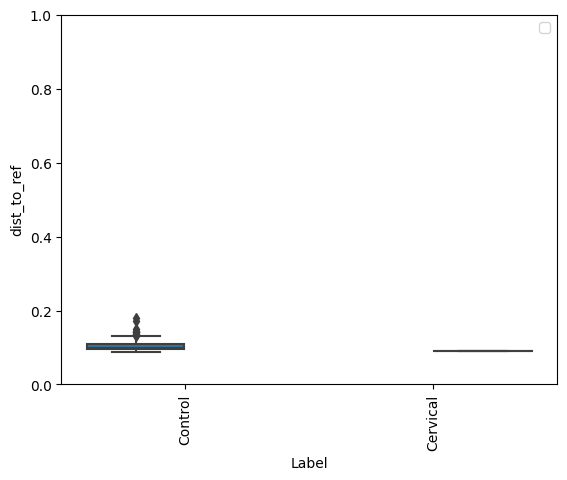

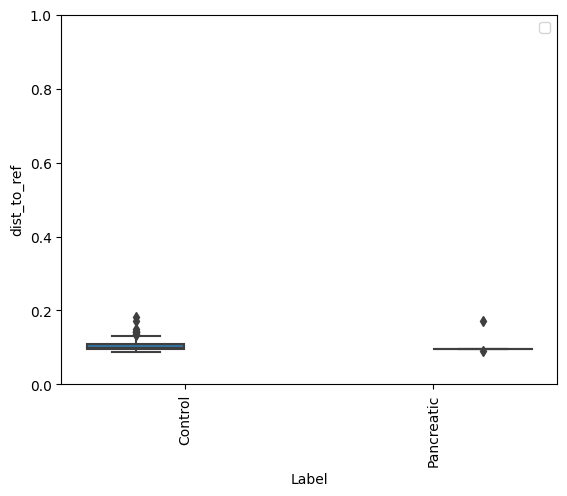

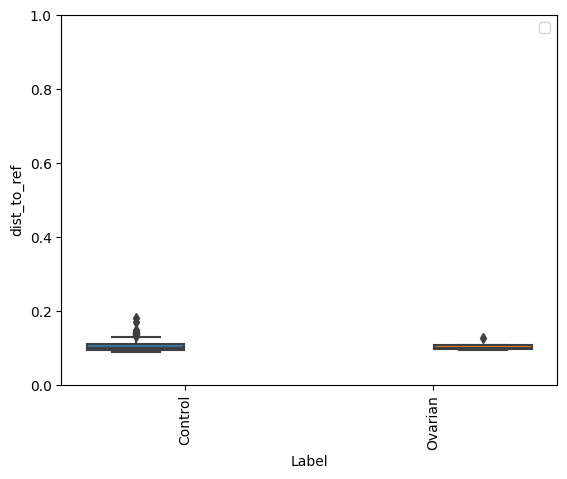

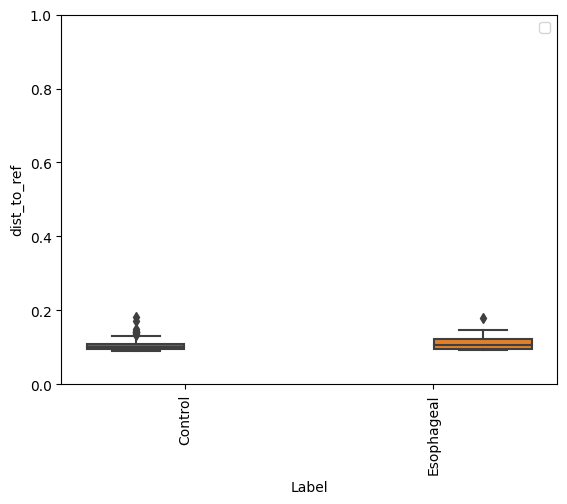

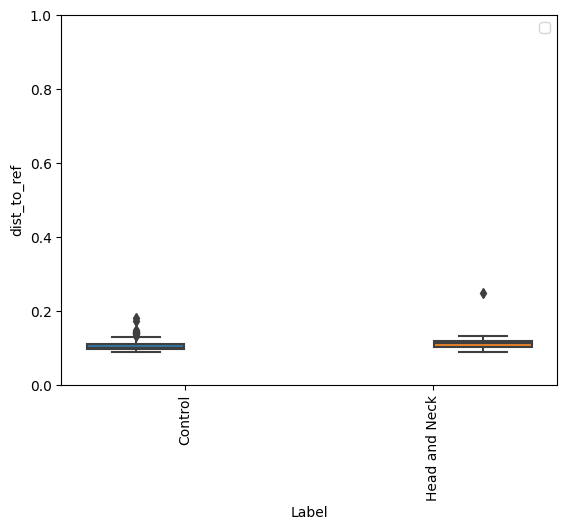

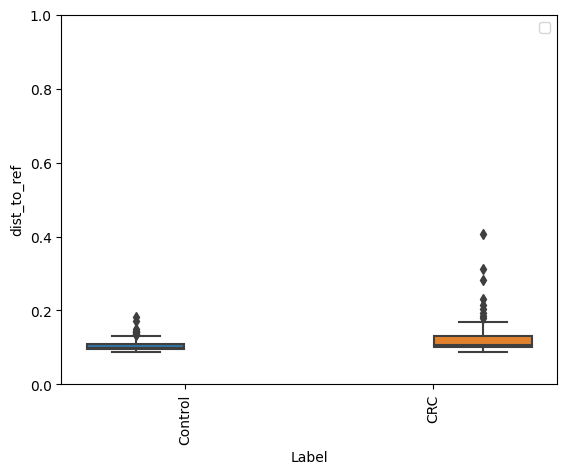

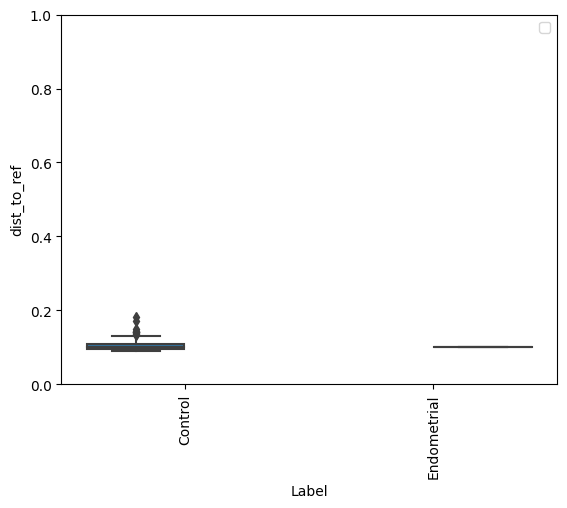

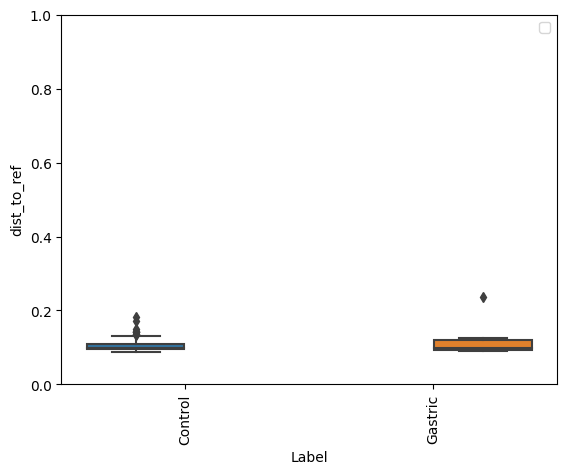

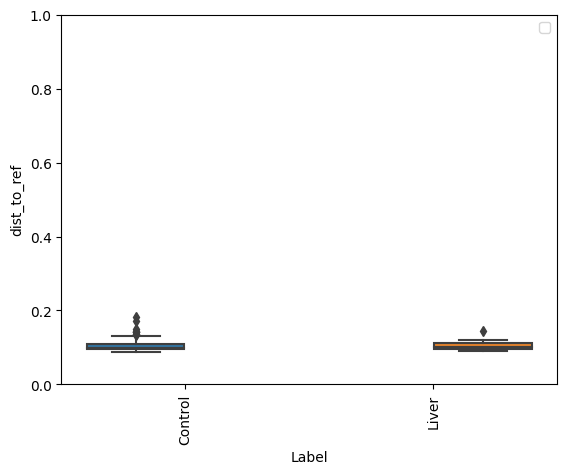

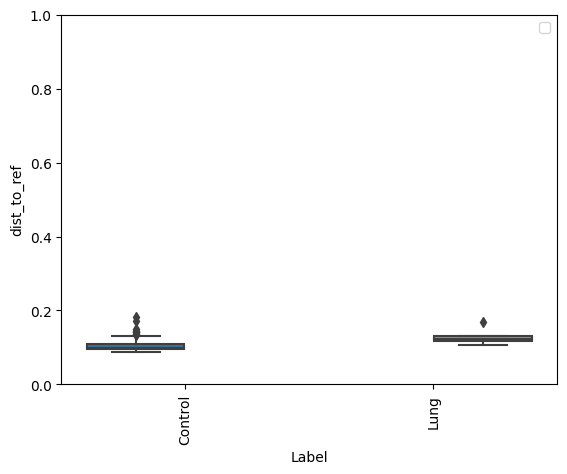

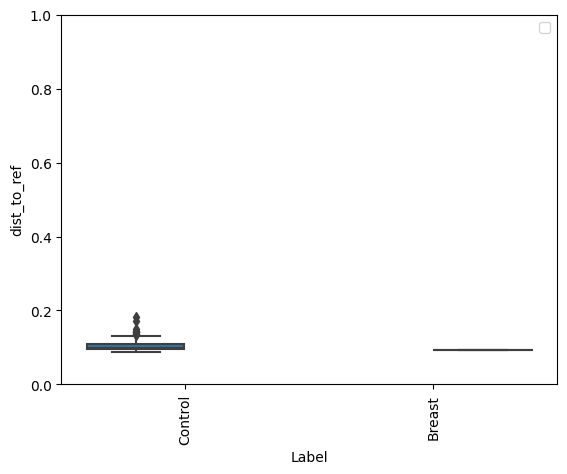

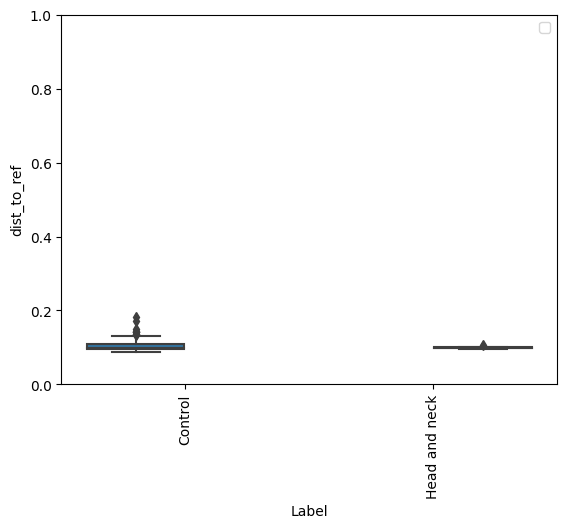

In [3]:
for input_cancer_class in [item for item in resdf.Label.unique() if item != "Control"]:
    sns.boxplot(data = resdf[resdf["Label"].isin(["Control", input_cancer_class])], x = "Label", y = "dist_to_ref", hue = "Label")
    plt.xticks(rotation=90)
    plt.legend([])
    plt.ylim([0, 1])
    plt.show()